In [1]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt


import torch
#from torch import Tensor as tensor
from torch import nn
from torch.nn  import functional as F
from torch.autograd import Variable

from scipy.integrate import odeint
from scipy.integrate import RK45


from torch.autograd.functional import jacobian
import random



use_cuda = torch.cuda.is_available() #also worsk for AMD-ROCm
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


# Pendelum
$$\frac{d^2 \theta}{dt^2}  +  \lambda\frac{d\theta}{dt} +  \frac{g}{l}sin(\theta) $$

In [2]:
def pend(y,t,b,c):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

b = 0.25
c = 5

theta_0 = np.pi
omega_0 = 1
 
y0 = [theta_0 , omega_0]

t_final = 10

t = np.arange(0, 10, 0.01)

sol = odeint(pend,y0, t, args=(b,c))


In [3]:
theta = 2*np.pi - sol[:, 0]
omega = sol[:, 1]

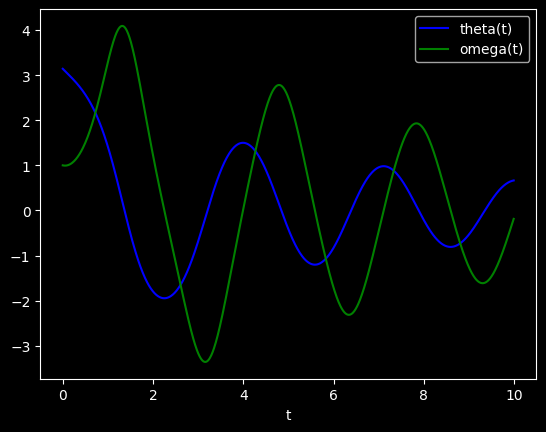

In [4]:
plt.plot(t, theta, 'b', label='theta(t)')
plt.plot(t, omega, 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.show()

# Neural ODE with ajoint-sensitivity-method

In [5]:
def ode_solve(func, x, propagation_time, delta_t, return_seq=False):
    """
    solves the differential equation : dx/dt = f(x(t)) using eulers method

    Parameters
    ----------
    func :  python function
            Parameters
            ----------
            x : torch.Tensor    

            Returns
            -------
            torch.Tensor
    
    x : torch.Tensor
        input for func (singlet or whole batch)

    propagation_time : float
    delta_t : float 
        accuracy of solution
    return_seq : bool
        flag for returning whole sequence or not

    
    Returns
    -------
    torch.tensor

    """
    time = torch.arange(start=0, end=propagation_time, step=delta_t, requires_grad=False)
    x = x.clone().detach()
    if not return_seq:
        for t in time:
            x = x + delta_t * func(x)
        return x
    if return_seq:
        outputs = torch.zeros(time.shape[0], x.shape[1])
        for i,_ in enumerate(time):
            x = x + delta_t * func(x)
            outputs[i] = x
        return outputs

In [6]:
class PendelumNetwork(nn.Module):
    def __init__(self):
        super(PendelumNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 5, dtype=float),
            nn.ReLU(),
            nn.Linear(5, 5, dtype=float),
            nn.ReLU(),
            nn.Linear(5, 2, dtype=float)
        )
    def forward(self,x): 
        """implements f(x)
        x = (theta, omega)
        theta ... angle
        omega ... angular velocity

        Parameters
        ----------
        x : torch.tensor 
            shape = (2,N)

        Returns
        -------
        torch.tensor

        """
        return self.linear_relu_stack(x)

    def flatten_parameters(self):
        flat_parameters = []
        for p in self.parameters():
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

    def get_adfdp(self, x , a ):
        temp = torch.mean( a.T @ self.forward(x.requires_grad_(True)))
        temp.backward(retain_graph=True)
        grads = []
        for param in self.parameters():
            grads.append(param.grad.view(-1))
        grads = torch.cat(grads)

        for param in self.parameters():
            param.grad.zero_() #clears accumulation
        return grads

    def this_is_a_test(self, x):
        return self.forward(x),x


In [13]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, flat_parameters, func, delta_t, propagation_time, return_seq=False):

        x_ = torch.tensor([[1,1],[1,1]], dtype = float, requires_grad=True)
        print(func.this_is_a_test(x_))
        assert isinstance(func, PendelumNetwork)
        if return_seq:
            return ode_solve(func, x,  propagation_time, delta_t, return_seq)
        else:
            output = ode_solve(func, x, propagation_time, delta_t, return_seq)
            ctx.func = func
            ctx.delta_t = delta_t
            ctx.propagation_time = propagation_time
            ctx.save_for_backward(output.clone(), flat_parameters)


            return output
        
    @staticmethod
    def backward(ctx, dL_dz):

        func = ctx.func
        delta_t = ctx.delta_t
        propagation_time = ctx.propagation_time
        x_1 , flat_parameters = ctx.saved_tensors
        a_1 =  (-1) * dL_dz.detach() # detach is very important

        def one_adjoint_backward_step(func, x_1, a_1, delta_t):
            a = a_1.clone().detach() 
            #x = x_1.clone().detach()
            outputs = func(x_1)
            a -= delta_t * torch.autograd.grad(outputs=outputs, inputs=x_1, grad_outputs=a)
            return a

        def one_euler_backward_step(func,x_1, delta_t):
            x = x_1.clone().detach()
            x -= delta_t * func(x)
            return x

        print("asdfasdf")
        print(one_euler_backward_step(func, x_1,delta_t))
        print("-------")


        def get_dL_dp(func, a_1, x_1, delta_t):
            time = torch.arange(start=0, end=propagation_time, step=delta_t, requires_grad=False)
            a = a_1.clone().detach() 
            x = x_1.clone().detach().requires_grad_(True)
            result = torch.zeros(func.flatten_parameters().shape)
            for t in time:
                result -= delta_t * func.get_adfdp(x,a)
                a = one_adjoint_backward_step(func, x, a, delta_t)
                x = one_euler_backward_step(func, x,delta_t)
            return result
        dLdp = get_dL_dp(func,a_1,x_1,delta_t)

        return None, dLdp, None, None, None, None

In [8]:
class NeuralODE(nn.Module):
    def __init__(self, func, delta_t):
        super(NeuralODE, self).__init__()
        self.func = func
        self.delta_t = delta_t
    
    def forward(self, x, propagation_time, return_seq=False):
        return ODEAdjoint.apply(x, self.func.flatten_parameters(), self.func, self.delta_t , propagation_time, return_seq)
        

In [9]:
def create_data_set(theta, omega, propagation_index=25, number_of_samples=200):
    """ x_i -> x_f
        x_i ... initial state
        x_f ... final state
        x_i = [theta_i, omega_i]
        x_f = [theta_f, omega_f]
        data_set = [[x_i, x_f]
                    [...]
                    ...
                    ]

    Parameters
    ----------
    theta : np.array or torch.tensor
        angle
    omega : np.array or torch.tensor
        angular velocity
   
    propagation_index : int
    
    number_of_samples : int
    
    Returns
    -------
    torch.tensor
    """
    x_i = []
    x_f = []
    data_set = torch.zeros((2,number_of_samples,2), dtype=float)
    while len(x_i) < number_of_samples:

        index = int(random.uniform(0, len(theta))) #selectes random index

        if index+propagation_index >= len(theta):
            continue

        x_i.append([theta[index], omega[index]])
        x_f.append([theta[index+propagation_index], omega[index+propagation_index]])
    x_i = torch.tensor(x_i)
    x_f = torch.tensor(x_f)
    data_set[0][:] = x_i
    data_set[1][:] = x_f
    return data_set.T

In [10]:
def create_batches(data_set, batch_size=64):
    """
    creates batches
    data is not shuffled and dropes last batch if size would be smaller than batch_size

    Parameters
    ----------
    data_set : troch.tensor 
        data_set[0] ... input
        data_set[1] ... output
    
        shape = (2,N_1,N_2)
        N_1 ... number of samples
        N_2 ... size of vector

    batch_size : int

    Retruns
    -------
    troch.tensor
    

    """
    number_of_batches = int(data_set.shape[1]/batch_size)
    batches = torch.zeros((number_of_batches,2,batch_size,data_set.shape[2]), dtype=float)
    for i in range(number_of_batches-1):
        batch = torch.zeros((2,batch_size,data_set.shape[2]), dtype=float)
        batch[0] = data_set[0][i*batch_size:(i+1)*batch_size][:]
        batch[1] = data_set[1][i*batch_size:(i+1)*batch_size][:] 
        batches[i] = batch
    
    return batches[:int(number_of_batches*0.75)], batches[int(number_of_batches*0.75):]


In [11]:
propagation_index = 25
propagation_time = t[propagation_index]
data_set = create_data_set(theta=theta, omega=omega, propagation_index=25)
train, test = create_batches(data_set, 64)
print(train.shape)
print(test.shape)


torch.Size([2, 2, 64, 2])
torch.Size([1, 2, 64, 2])


/tmp/ipykernel_46025/1055520759.py:43: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  return data_set.T


In [14]:
#training
epoch = 200
delta_t = 0.01

func = PendelumNetwork()
model = NeuralODE(func, delta_t)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


for k in range(epoch):
    avg_los = 0
    for train_batch in train:
        x_i, x_f = train_batch
        prediction = model(x_i, propagation_time)
       
        loss = torch.mean(torch.norm((prediction - x_f),dim=1)**2)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_los += loss.item()
    if k%10==0:
        avg_los_2 = 0
        for test_batch in test:
            x_i, x_f = test_batch
            prediction_ = model(x_i, propagation_time)
            #loss_ = 1/2 * (prediction - x_f).T@(prediction - x_f)
            #avg_los_2 += loss_.item()

        avg_los = avg_los/64
        avg_los_2 = avg_los_2/64
        print(k , "\t training ",avg_los)
        print(" \t validation ",avg_los_2)
        print("_________")


(tensor([[ 0.2408, -0.4033],
        [ 0.2408, -0.4033]], dtype=torch.float64), tensor([[1., 1.],
        [1., 1.]], dtype=torch.float64, requires_grad=True))
asdfasdf


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

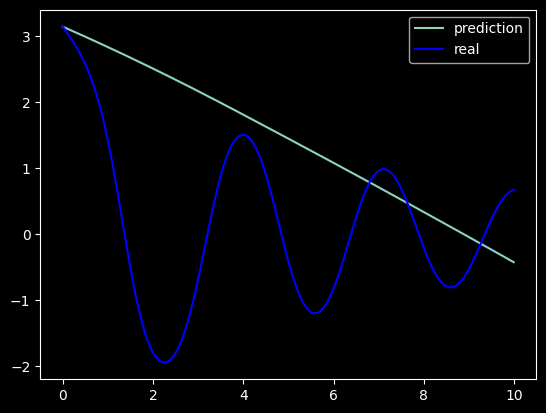

In [ ]:
prediction = model(torch.tensor([[theta[0], omega[0]]],dtype=float), 10, True).T[0].detach().numpy()

plt.plot(np.arange(0, 10, delta_t),prediction, label="prediction")
plt.plot(t, theta, color='b',label="real")
plt.legend()
plt.show()